# Implementing a simple stream power law with `DAGGER`

This notebook assumes you are comfortable with the basics of `DAGGER` (what is a DAG, a graph, a connector, ...). 
   
In this tutorial we will implement a simple explicit solver for the simplest expression of the Stream Power Law (Howard and Kerby, 1983). It simply describe the evolution of topography through time with an advective power law equation linking drainage area, Slope and local condictions (climate, lithology, ...).

First let's import what we need and generate an initial landscape with white noise.


In [1]:
import dagger as dag
from helper import load_raster
import matplotlib.pyplot as plt
import numpy as np
import time
# The following line is a jupyter lab command telling it to use the interactive widget ipympl for matplotlib
%matplotlib widget

## Generate initial conditions

To generate initial conditions we simply need the dimension and resolution of the landscape:

In [2]:
# number of nodes in the X/Y directions
nx,ny = 200,200
# Resolution in the X/Y directions
dx,dy = 200,200
# generating hte white noise
topo = np.random.rand(ny*nx)+5

We can then create the connector and the graph:

In [3]:
con = dag.D4N(nx, ny, dx, dy, 0, 0)
gf = dag.graphD4(nx * ny, 8)
gf.init_graph(con)

Now we can focus on the stream power law and its resolution. The driving equation is:

\begin{equation}
\frac{dz}{dx} = U(x) -  K(x) (\frac{dz}{dx})^n A(x)^m
\end{equation}

- `U` is the surface uplift and for simplicity we give it a fixed value
- `m` and `n` are exponents which values are widely debated but linked to the erosional/hydraulic processes
- `K` is the erodability and represent rock strength, climate, .... Again we consider a single value but one could eventually use a spatially varying one to simulate multiple rock types
- `dt` is the time step, because we are solving the model explicitly, high values can make the model unstable (it's highly function of all the other parameters) and we will present an implicit alternative later, as it leverages even more aspects of `DAGGER`.

Here We provide common ranges of parameters.

In [4]:
# SPL exponents
m,n = 0.45,1
# Erodability
K = 2e-4
# Surface uplift
U = 0.8e-3
# timestep
dt = 1000
# ndt = number of time steps
ndt = 500

## Running the model

Apart from the above parameters that are externally given to the equation, we need to calculate (i) drainage area (A) and (ii) the topographic Slope. This can be tedious to do manually, but thanks to `DAGGER` the workflow is quite straightforward:

1) Compute the graph to update the receivers/donors - Here we only need Single flow graph using `gf.compute_graph`
2) Compute the drainage area with `accumulate_constant_downstream_SFD`
3) Compute the Slope using the Single flow receivers (`get_SFD_receivers`) and the distance to receivers (`get_SFD_dx`)
4) Calculating and applying the changes in `dz`
5) Back to 1.

### Scenario I: no local minima solver

We will start with a simple scenario where we turn off local minima solver. The topography evolves slowly and gradually without jumps in drainage area, keeping hte weak explicit scheme stable.


(we will update the topographic plot live)

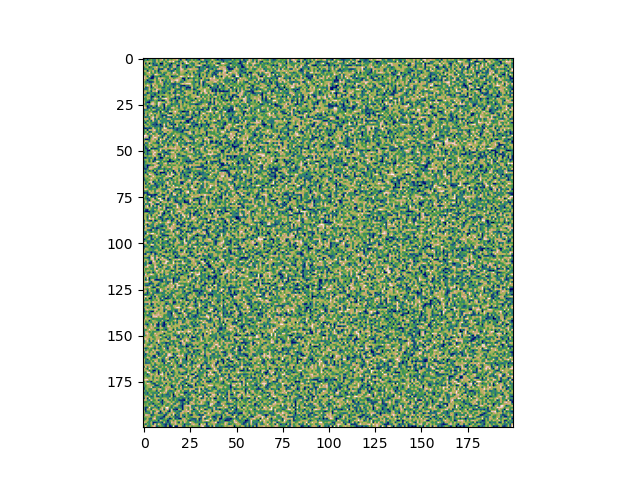

In [5]:
fig,ax = plt.subplots()
im = ax.imshow(topo.reshape(ny,nx), cmap = "gist_earth")

In [6]:
for i in range(ndt):
    # print(i)
    gf.set_LMR_method(dag.LMR.none)
    gf.compute_graph(topo, con, True, True)
    A = gf.accumulate_constant_downstream_SFD(con, 900)
    Srec = gf.get_SFD_receivers()
    Sdist = gf.get_SFD_dx()
    Sdist[Sdist <= 0] = 1e3
    S = (topo - topo[Srec]) / Sdist
    S[S<1e-6] = 1e-6
    E = np.power(S,n) * np.power(A,m) * K
    topo = topo - (E - U) * dt
    topo = topo.reshape(ny,nx)
    topo[[0,-1],:] = 0
    topo[:,[0,-1]] = 0
    topo[np.isfinite(topo) == False] = 0
    if(i%5 == 0):
        im = ax.imshow(topo.reshape(ny,nx), cmap = "gist_earth")
        fig.canvas.draw()
    topo = topo.reshape(ny*nx)
    

KeyboardInterrupt: 

## Scenario II: Local minima solver

The above scenario shows very geometrical geomoetries. this is mostly because the initial random noise does not precondition any flow and the edges gradually "eat" their way toward the inside. One way to bypass that and create more realistic rivers is to solve the local minima simulating fow path as if all depression were drained. `Dagger` offers a variety of ways to do so (see dedicated notebook). 

However, this makes the model start with a huge drainage area and we need to reduce the `dt` to keep the scheme stable - too much erosion create numerical divergence. We will address that later. 

Note how the rivers for more natural paths and more importantly more rapidely.

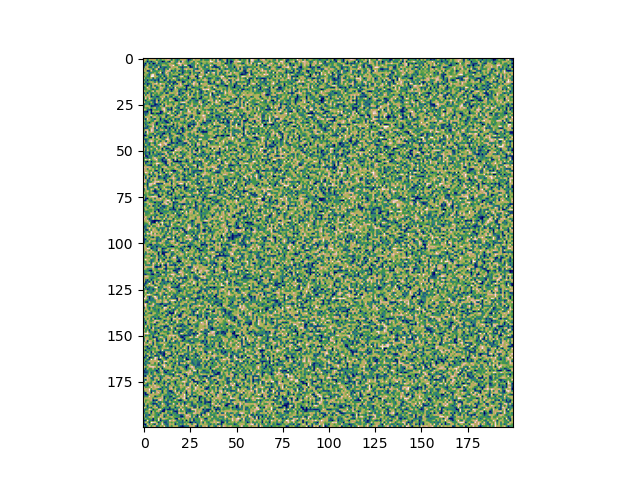

In [7]:
# number of nodes in the X/Y directions
nx,ny = 200,200
# Resolution in the X/Y directions
dx,dy = 200,200
# generating hte white noise
topo = np.random.rand(ny*nx)+5

con = dag.D8N(nx, ny, dx, dy, 0, 0)
gf = dag.graph(nx * ny, 8)
gf.init_graph(con)

# SPL exponents
m,n = 0.45,1
# Erodability
K = 2e-4
# Surface uplift
U = 0.8e-3
# timestep
dt = 500
# ndt = number of time steps
ndt = 500

fig,ax = plt.subplots()
im = ax.imshow(topo.reshape(ny,nx), cmap = "gist_earth")

In [8]:
for i in range(ndt):
    gf.set_LMR_method(dag.LMR.cordonnier_carve)
    gf.compute_graph(topo, con, True, True)
    A = gf.accumulate_constant_downstream_SFD(con, 900)
    Srec = gf.get_SFD_receivers()
    Sdist = gf.get_SFD_dx()
    Sdist[Sdist <= 0] = 1e3
    S = (topo - topo[Srec]) / Sdist
    S[S<1e-6] = 1e-6
    E = np.power(S,n) * np.power(A,m) * K
    topo = topo - (E - U) * dt
    topo = topo.reshape(ny,nx)
    topo[[0,-1],:] = 0
    topo[:,[0,-1]] = 0
    topo[np.isfinite(topo) == False] = 0
    if(i%5 == 0):
        im = ax.imshow(topo.reshape(ny,nx), cmap = "gist_earth")
        fig.canvas.draw()
    topo = topo.reshape(ny*nx)

KeyboardInterrupt: 

If you play with all the parameters, you can quickly see that the model becomes rapidly unstable if:

- we increase K/m/n 
- increase the domain size
- reduce resolution

This is due to the Courant conditions that are inherent to explicit formulation. While in a lot of situation it is not possible/worth it to bypass this problem, the basic version of the stream power equation has very elegant implicit schemes (therefore unconditionally stable).

## Solving the SPL implicitely 

We will use the formulation of Braun and Willett (2013). Long story short it assumes a known elevation at the outlet and a calculatable drainage area to propagate a solution upstream.

**Add equation here**

To solve that equation we face two challenges:

1) It requires to iterate through all the model nodes in a specific order: from the most downstream nodes to the most upstream ones. In graph theory, this is called a tolopogical sorting orperation and fortunately `DAGGER` provide the `stack` array from the graph object (sensu Braun and Willett 2013) which does exactly that. It can be obtained with the `get_SFD_stack` function of the graph.

2) Iterating manually through a large array is not oprimal in `python` (it simply is not designed for that). Because of the topological order constrain, we cannot vectorise the operation with `numpy` like we did above and solving it in pure python would be slow. Thanksfully many solutions exists from coding in another language and bind the function to `python` (`fortran, C, C++, Julia` are designed for that kind of computing), or use `python`-based solutions (`pypy, cython or numba`). Here we use `numba`, which compiles compatible `python` functions to `assembly` using `llvm`. Long story short, it makes loop fast as long as it is written in a certain style (very `numpy` compatible) and that is what we are doing bellow:



In [3]:
import numba as nb


@nb.jit(nopython = True)
def SPL_implicit(elevation, stack, receivers, dist2receivers,
         area, k, m, n, dt, tolerance, nnodes):
    bung = 0
    for inode in range(nnodes):
        istack = stack[inode]
        irec = receivers[istack]


        if irec == istack:
            # no erosion at basin outlets
            continue

        factor = k * dt * area[istack]**m / dist2receivers[istack]**n
        # if(dist2receivers[istack] == 0):
        #     print(istack,"|", end = "")
        #     bung+=1

        ielevation = elevation[istack]
        irec_elevation = elevation[irec]

        # iterate: lower elevation until convergence
        elevation_k = ielevation
        elevation_prev = np.inf

        while abs(elevation_k - elevation_prev) > tolerance:
            elevation_prev = elevation_k
            slope = max(elevation_k - irec_elevation,1e-6)
            diff = ((elevation_k - ielevation + factor * (slope)**n) /
              (1. + factor * n * slope**(n - 1)))
            elevation_k -= diff

        elevation[istack] = elevation_k
    # print(bung)

### Scenario III: Solving large domains with implicit SPL and `DAGGER`

Now our equation is unconditionnaly stable, we can run much bigger landscapes with much bigger timesteps.
See bellow:

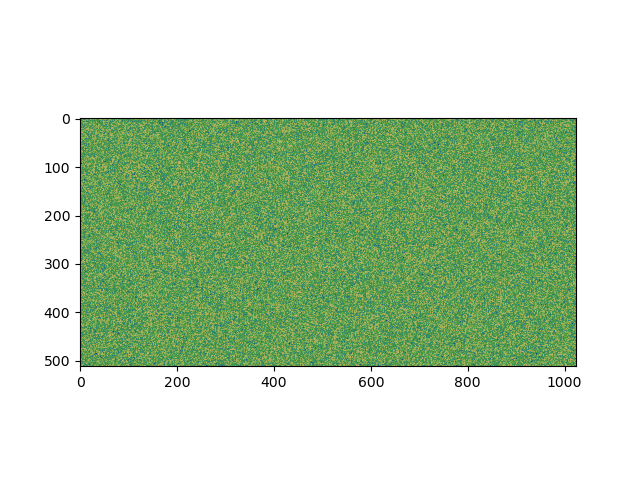

In [4]:
# number of nodes in the X/Y directions
nx,ny = 1024,512
# Resolution in the X/Y directions
dx,dy = 200,200
# generating hte white noise
topo = np.random.rand(ny*nx)+5

con = dag.D8N(nx, ny, dx, dy, 0, 0)
gf = dag.graph(nx * ny, 8)
gf.init_graph(con)

# SPL exponents
m,n = 0.45,1
# Erodability
K = 2e-4
# Surface uplift
U = 0.8e-3
# timestep
dt = 50000
# ndt = number of time steps
ndt = 2000

fig,ax = plt.subplots()
im = ax.imshow(topo.reshape(ny,nx), cmap = "gist_earth")

In [ ]:
# Running the SPL for ndt timesteps
for i in range(1000):
    # Comuting the graph with a fill algorithm and only for Single Flow
    gf.set_LMR_method(dag.LMR.cordonnier_carve)
    gf.compute_graph(topo, con, True, True)
    # Getting drainage area
    A = gf.accumulate_constant_downstream_SFD(con, 900)
    # The array pointing the the node index of the receiver for each nodes (itself if no receivers by convention)
    Srec = gf.get_SFD_receivers()
    # dx corresponding to the receivers array above
    Sdist = gf.get_SFD_dx()
    # The topological ordering
    stack = gf.get_SFD_stack()
    # Eroding the topography
    SPL_implicit(topo, stack, Srec, Sdist, A, K, m, n, dt, 1e-3, nx * ny)
    # Adding the uplift
    topo += U * dt
    # Setting boundaries to 0
    con.set_values_at_boundaries(topo,0)
    # Updating the plot
    if(i%5 == 0):
        im = ax.imshow(topo.reshape(ny,nx), cmap = "gist_earth")
        fig.canvas.draw()